# Phishing Detection: Feature Extraction and Construction of a Machine Learning model

In this brief project, we'll develop a ML model to predict whether an URL is used for phishing. We'll start from a raw dataset with just two columns:

- **URL:** URL string
- **Label:** Binary variable ('bad' if the URL is malicious and 'good' otherwise)

In [1]:
#Importing necessary libraries
!pip install tldextract
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import randint, uniform
import random
from sklearn.model_selection import KFold, cross_val_score
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
from scipy.stats import entropy
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 3.7 MB/s eta 0:00:00


We import the raw dataset.

In [2]:
X = pd.read_csv('/kaggle/input/phishing-site-urls/phishing_site_urls.csv')

X['URL'].str.strip()  # Remove unnecessary whitespaces

X

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad


## Study of Special Characters in 'bad' URLs

Besides dots (.) and slashes (/), there are other non-alphanumerical characters that appear in URLs and some of them are often associated to malicious websites. From now on we'll use the term ***special character*** to refer to non-alphanumerical characters different from dots and slashes. To study the frequencies of special characters in bad URLs we'll construct a dataframe with three columns:

- **Special Character:** this column contains special characters that appear in the bad URLs of the dataset.
- **Frequency in bad URLs:** number of bad URLs in which the special character appears.
- **Bad probability:** percentage of bad URLs in which the special character appears over all of the URLs in which the special character appears.
- **Danger Score:** the danger score of the URL is calculated as follows

$$\text{Danger score} = \text{Bad probability}\cdot \log(\text{Frequency in bad URLs})$$

In [3]:
special_df = pd.DataFrame()

special_chars = set() 

def find_special_char(x):
    special_chars_in_x = re.findall(r'[^a-zA-Z0-9]', x)
    special_chars.update(special_chars_in_x)
    return None

X_bad = X[X['Label'] == 'bad']
X_bad['URL'].apply(find_special_char)

special_chars = list(special_chars)

special_chars.remove('.')
special_chars.remove('/')

special_df['Special Character'] = special_chars
special_df['Frequency in bad URLs'] = special_df['Special Character'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0])
special_df['Bad probability'] = special_df['Frequency in bad URLs']/special_df['Special Character'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0])
special_df['Score'] = special_df['Bad probability']*special_df['Frequency in bad URLs'].apply(math.log)

special_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
special_df

,Special Character,Frequency in bad URLs,Bad probability,Score
0,\,6363,0.966874,8.468132
1,;,11294,0.906639,8.460778
2,,1066,0.955197,6.659318
3,@,1809,0.882870,6.621990
4,',3591,0.774089,6.336839
...,...,...,...,...
167,,1,0.040000,0.000000
168,Ý,1,0.034483,0.000000
169,÷,1,0.038462,0.000000
170,Ö,1,0.031250,0.000000


From now on we'll call the top ten characters of this list ***dangerous characters***. 

['\\', ';', ' ', '@', "'", ':', '&', '>', '<', '=']


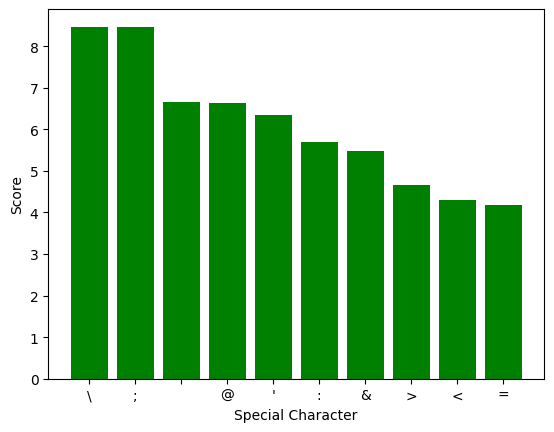

In [4]:
dangerous_chars = list(special_df['Special Character'].head(10))
print(dangerous_chars)
plt.bar(special_df['Special Character'].head(10), special_df['Score'].head(10), color = 'green')
plt.xlabel('Special Character')
plt.ylabel('Score')
plt.show()

## Study of TLDs in 'bad' URLs

Similarly to what we did before, we want to study the TLDs of our 'bad' URLs and extract the top 10 most dangerous of them. The approach will be basically the same as before.

In [5]:
TLD_df = pd.DataFrame()

TLD_list = pd.Series(X_bad['URL'].apply(lambda x: tldextract.extract(x).suffix)).unique()

TLD_df['TLD'] = TLD_list

TLD_df['Frequency in bad URLs'] = TLD_df['TLD'].apply(lambda x: X_bad[X_bad['URL'].str.contains(re.escape(x), regex=True)].shape[0])
TLD_df['Bad probability'] = TLD_df['Frequency in bad URLs']/TLD_df['TLD'].apply(lambda x: X[X['URL'].str.contains(re.escape(x), regex=True)].shape[0])
TLD_df['Score'] = TLD_df['Bad probability']*TLD_df['Frequency in bad URLs'].apply(math.log)

TLD_df.sort_values(by='Score', ignore_index=True, ascending=False, inplace=True)
TLD_df

,TLD,Frequency in bad URLs,Bad probability,Score
0,com.br,4235,0.982599,8.205817
1,mx,3698,0.931486,7.652669
2,cm,10508,0.812495,7.523618
3,bf,3900,0.878576,7.264711
4,date,5402,0.775258,6.662977
...,...,...,...,...
601,com.bb,1,1.000000,0.000000
602,sa.edu.au,1,0.142857,0.000000
603,gob.do,1,1.000000,0.000000
604,edu.bt,1,1.000000,0.000000


['com.br', 'mx', 'cm', 'bf', 'date', 'run', 'xyz', 'mg', 'com.ar', 'ph']


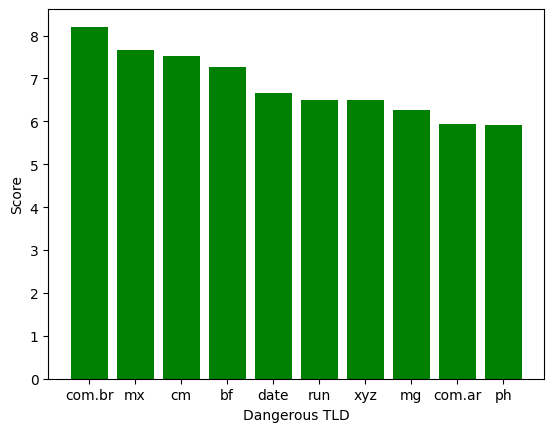

In [6]:
dangerous_TLDs = list(TLD_df['TLD'].head(10))
print(dangerous_TLDs)
plt.bar(TLD_df['TLD'].head(10), TLD_df['Score'].head(10), color = 'green')
plt.xlabel('Dangerous TLD')
plt.ylabel('Score')
plt.show()

These are the top 10 most dangerous TLDs in our dataframe (we'll call them ***dangerous TLDs***). So a URL that contains one of these TLDs is more likely to be "bad".

## Feature Extraction

We'll extract the following features from the raw data:

- **URL length:** total length of the URL string.
- **Number of dots:** number of dots in the URL.
- **Number of slashes:**  number of slashes in the URL.
- **Percentage of numerical characters:** percentage of numerical characters in the URL.
- **Dangerous characters:** binary variable (True if there is a dangerous character in the URL and False otherwise)
- **Dangerous TLD:** binary variable (True if the TLD of the URL is dangerous and False otherwise)
- **Entropy:** Entropy of the URL .
- **IP address:** binary variable (True if there is an IP address in the URL and False otherwise).
- **Domain name length:** length of the main domain part (e.g. www.alligator.it has domain name lenght equal to 9).
- **Suspicious keywords:** binary variable (True if there are suspicious keywords in the domain or path such as "login", "secure", "verify", "bank" and False otherwise). We'll use the following list of suspicious words 

    [secure, account, update, login, verify ,signin, bank,notify, click, inconvenient]
                      
     A reference for this list is *D. Ranganayakulu, Chellappan C.,Detecting Malicious URLs in E-mail – An Implementation, 2013, AASRI Procedia*.

- **Repetitions:**  binary variable (True if the domain contains a substring of three identical characters and False otherwise).
- **Redirections:** We remember that a double slash // in a URL corresponds to a redirection. Redirections are not necessarily malicious, but they may be if they aren't at the beginning at the URL. So Redirections is a binary variable (True if there is a // in a position higher than 7 and False otherwise, where by position of // we mean the position of the the character that preceds //). The bound 7 is chosen in order to avoid including the (generally safe) redirection of https:// and similar cases.


In [7]:

#1 URL length

X['URL length'] = X['URL'].apply(len)

#2 Numbers of dots

X['Number of dots'] = X['URL'].apply(lambda x: x.count('.'))

#3 Number of slashes

X['Number of slashes'] = X['URL'].apply(lambda x: x.count('/'))

#4 Percentage of numerical characters

X['Percentage of numerical characters'] = X['URL'].apply(lambda x: sum(c.isdigit() for c in x))/X['URL length']

#5 Dangerous characters

X['Dangerous characters'] = X['URL'].apply(lambda x: any(char in x for char in dangerous_chars))

#6 Dangerous TLD

X['Dangerous TLD'] = X['URL'].apply(lambda x: tldextract.extract(x).suffix in dangerous_TLDs)

#7 Entropy

def urlentropy(url):
    frequencies = Counter(url)
    prob = [frequencies[char] / len(url) for char in url]
    return entropy(prob, base=2)


X['Entropy'] = X['URL'].apply(urlentropy)

#8 IP Address

ip_pattern = r'[0-9]+(?:\.[0-9]+){3}'
X['IP Address'] = X['URL'].apply(lambda x: bool(re.search(ip_pattern, x)))

#9 Domain name length

X['Domain name length'] = X['URL'].apply(lambda x: len(tldextract.extract(x).domain))

#10 Suspicious keywords

sus_words = ['secure', 'account', 'update', 'login', 'verify' ,'signin', 'bank',
            'notify', 'click', 'inconvenient']

X['Suspicious keywords'] = X['URL'].apply(lambda x: sum([word in x for word in sus_words]) != 0)


#11 Repetitions

X['Repetitions'] = X['URL'].apply(lambda x: True if re.search(r'(.)\1{2,}', tldextract.extract(x).domain) else False)

#12 Redirections

def redirection(url):
  pos = url.rfind('//') #If the // is not found, it returns -1
  return pos>7

X['Redirections'] = X['URL'].apply(redirection)

#We print the new dataset

X

,URL,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,225,6,10,0.257778,True,False,7.667575,False,6,True,False,False
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,81,5,4,0.012346,True,False,6.190289,False,7,False,False,False
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,177,7,11,0.265537,False,False,7.288285,False,12,True,False,False
3,mail.printakid.com/www.online.americanexpress....,bad,60,6,2,0.000000,False,False,5.786667,False,9,False,False,False
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,116,1,10,0.181034,False,False,6.611978,False,15,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,15,3,1,0.733333,False,False,3.693150,True,14,False,False,False
549342,apple-checker.org/,bad,18,1,1,0.000000,False,False,4.031402,False,13,False,False,False
549343,apple-iclods.org/,bad,17,1,1,0.000000,False,False,4.001823,False,12,False,False,False
549344,apple-uptoday.org/,bad,18,1,1,0.000000,False,False,4.012188,False,13,False,False,False


## Exploratory Data Analysis and Feature Engineering

We standardize numerical features (except the **Percentage of numerical characters**).

In [8]:
scaler = StandardScaler()

num_columns = ['URL length', 'Number of dots', 'Number of slashes', 'Domain name length', 'Entropy']

X[num_columns] = scaler.fit_transform(X[num_columns])

We turn the boolean features and the target Label  into numerical data. Moreover we drop the **URL** feature because it's no longer useful.

In [9]:
X['IP Address'] = X['IP Address'].astype(int)
X['Suspicious keywords'] = X['Suspicious keywords'].astype(int)
X['Repetitions'] = X['Repetitions'].astype(int)
X['Redirections'] = X['Redirections'].astype(int)
X['Dangerous characters'] = X['Dangerous characters'].astype(int)
X['Dangerous TLD'] = X['Dangerous TLD'].astype(int)
X['Label'] = (X['Label'] == 'good').astype(int)

X.drop(columns=['URL'], inplace=True)

X

,Label,URL length,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,Entropy,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections
0,0,3.923264,2.599770,4.734477,0.257778,1,0,3.043151,0,-0.799120,1,0,0
1,0,0.681338,1.939541,0.974386,0.012346,1,0,1.213456,0,-0.582586,0,0,0
2,0,2.842622,3.259998,5.361159,0.265537,0,0,2.573382,0,0.500083,1,0,0
3,0,0.208557,2.599770,-0.278978,0.000000,0,0,0.713550,0,-0.149518,0,0,0
4,0,1.469306,-0.701371,4.734477,0.181034,0,0,1.735740,0,1.149685,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,-0.804544,0.619085,-0.905660,0.733333,0,0,-1.879379,1,0.933151,0,0,0
549342,0,-0.737004,-0.701371,-0.905660,0.000000,0,0,-1.460437,0,0.716617,0,0,0
549343,0,-0.759518,-0.701371,-0.905660,0.000000,0,0,-1.497072,0,0.500083,0,0,0
549344,0,-0.737004,-0.701371,-0.905660,0.000000,0,0,-1.484234,0,0.716617,0,0,0


To appreciate the correlation between features (and target) we print the heat maps of the correlation matrix and of the correlation vector with Label (our target).

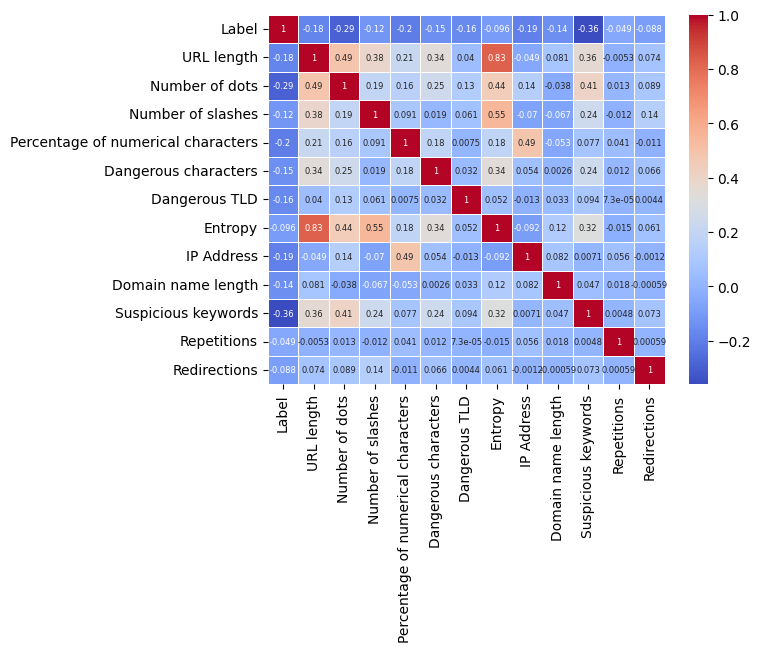

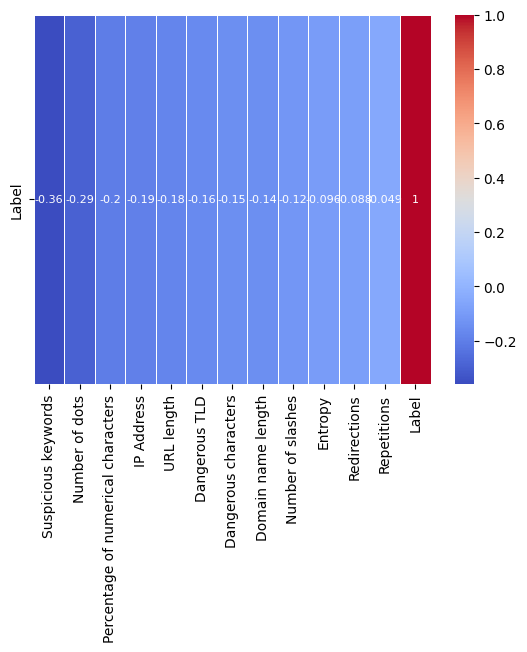

                                       Label
Suspicious keywords                -0.360325
Number of dots                     -0.293474
Percentage of numerical characters -0.204039
IP Address                         -0.191832
URL length                         -0.177295
Dangerous TLD                      -0.163621
Dangerous characters               -0.146440
Domain name length                 -0.144385
Number of slashes                  -0.118405
Entropy                            -0.096089
Redirections                       -0.088167
Repetitions                        -0.049215
Label                               1.000000


In [10]:
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 6})
plt.show()
sns.heatmap(corr_matrix[['Label']].sort_values(by='Label').T, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.show()
print(corr_matrix[['Label']].sort_values(by='Label'))

**Entropy** and  **URL Length** are highly correlated, so we apply PCA.

In [11]:
pca = PCA(n_components=1)
X['Entropy and length (PCA)'] = pca.fit_transform(X[['Entropy', 'URL length']])
X.drop(columns=['Entropy', 'URL length'], inplace=True)

X

,Label,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections,Entropy and length (PCA)
0,0,2.599770,4.734477,0.257778,1,0,0,-0.799120,1,0,0,4.926000
1,0,1.939541,0.974386,0.012346,1,0,0,-0.582586,0,0,0,1.339822
2,0,3.259998,5.361159,0.265537,0,0,0,0.500083,1,0,0,3.829693
3,0,2.599770,-0.278978,0.000000,0,0,0,-0.149518,0,0,0,0.652028
4,0,-0.701371,4.734477,0.181034,0,0,0,1.149685,0,0,1,2.266310
...,...,...,...,...,...,...,...,...,...,...,...,...
549341,0,0.619085,-0.905660,0.733333,0,0,1,0.933151,0,0,0,-1.897821
549342,0,-0.701371,-0.905660,0.000000,0,0,0,0.716617,0,0,0,-1.553825
549343,0,-0.701371,-0.905660,0.000000,0,0,0,0.500083,0,0,0,-1.595650
549344,0,-0.701371,-0.905660,0.000000,0,0,0,0.716617,0,0,0,-1.570652


## Train-Test Split

Since we are working with a binary classification problem, it's important to make sure that both classes ('bad' and 'good') are approximately equally represented in the dataset.

In [12]:
X['Label'].value_counts(normalize=True)

Label
1    0.715258
0    0.284742
Name: proportion, dtype: float64

To solve the disproportion in the dataset, we'll undersample the 'good' records (we'll conserve also the not sampled 'good' records for the testing step).

In [13]:
n_samples = X['Label'].value_counts()[0]
X_good = X[X['Label'] == 1]
X_bad = X[X['Label'] == 0]
X_goodsample = X_good.sample(n=n_samples, random_state=22)
X_goodmissing = X_good.drop(X_goodsample.index)

X = pd.concat([X_bad, X_goodsample], ignore_index=True)

X

,Label,Number of dots,Number of slashes,Percentage of numerical characters,Dangerous characters,Dangerous TLD,IP Address,Domain name length,Suspicious keywords,Repetitions,Redirections,Entropy and length (PCA)
0,0,2.599770,4.734477,0.257778,1,0,0,-0.799120,1,0,0,4.926000
1,0,1.939541,0.974386,0.012346,1,0,0,-0.582586,0,0,0,1.339822
2,0,3.259998,5.361159,0.265537,0,0,0,0.500083,1,0,0,3.829693
3,0,2.599770,-0.278978,0.000000,0,0,0,-0.149518,0,0,0,0.652028
4,0,-0.701371,4.734477,0.181034,0,0,0,1.149685,0,0,1,2.266310
...,...,...,...,...,...,...,...,...,...,...,...,...
312839,1,-0.701371,-0.905660,0.000000,0,0,0,-0.582586,0,0,0,-0.692077
312840,1,-0.041143,-0.278978,0.000000,0,0,0,-0.149518,0,0,0,-0.964574
312841,1,-0.041143,0.347704,0.000000,0,0,0,-1.448721,0,0,0,-0.415293
312842,1,-0.041143,-0.905660,0.000000,0,0,0,-0.366052,0,0,0,-0.232647


We divide features from target.

In [14]:
y = X['Label']
X.drop(columns=['Label'], inplace=True)

We split the data into training set and test set. We also add the 'good' URL we discarded previously to the test set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

y_goodmissing = X_goodmissing['Label']
X_goodmissing.drop(columns=['Label'], inplace=True)

# Merging X_test and X_goodmissing

X_test = pd.concat([X_test, X_goodmissing], axis=0)

# Merging y_test and y_goodmissing

y_test = pd.concat([y_test, y_goodmissing], axis=0)

## Construction of a ML model

We try two model: XGBClassifier and RandomForestClassifier. To avoid overfitting, we'll perform a cross-validation with 3 folds.

In [16]:
kf = KFold(n_splits=3, shuffle=True, random_state=22)

xgb_model = XGBClassifier(random_state=22)
print(cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='accuracy').mean())

rf_model = RandomForestClassifier(random_state=22)
print(cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy').mean())

0.8392927779442613
0.8603096593746878


The CV score of the RandomForestClassifier is slightly superior. We fit the two models and analyze the feature importances.

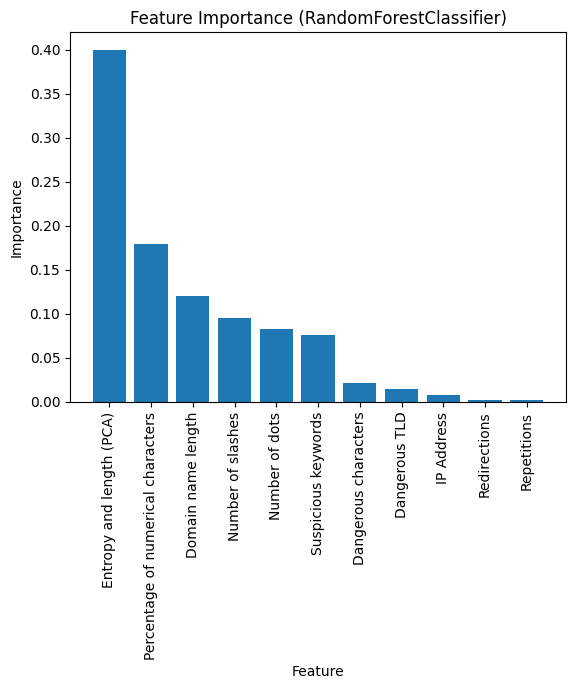

In [17]:
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (RandomForestClassifier)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


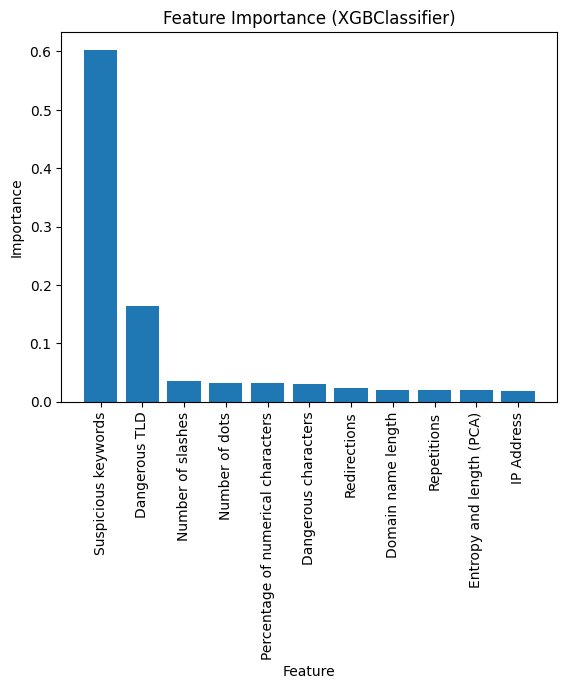

In [18]:
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feature_names = X.columns 
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance (XGBClassifier)')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

The two models, while having similar performances, give completely different feature importances. It's not entirely clear to us why this happens.

We test the two models.

In [19]:
from sklearn.metrics import accuracy_score

rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

print(accuracy_score(y_test, rf_pred))
print(accuracy_score(y_test, xgb_pred))

0.8643532806591077
0.8640824419619422


The accuracy of the two models is basically the same (86.4 %).

## Hyperparameters Tuning

For computational reasons, we'll try to tune only the XGBClassifier model to improve its CV score (and hopefully its accuracy). We'll use a Bayesian Optimization method.

In [21]:
import optuna



def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 400)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 0.3)
    subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-3, 10.0)

    
    model = XGBClassifier(
        random_state=22,
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        reg_alpha=reg_alpha,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    
    mean_score = cross_val_score(model, X, y, cv=kf, scoring='accuracy').mean()
    return mean_score 


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) 


print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

best_xgb_model =XGBClassifier(random_state=22, **study.best_params)

[I 2024-09-21 19:10:54,838] A new study created in memory with name: no-name-e271e608-4baf-46d8-8d92-61a22b496b42
[I 2024-09-21 19:11:00,640] Trial 0 finished with value: 0.8248903584906192 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.10695456185737169, 'subsample': 0.894212510130636, 'reg_alpha': 0.30329682286839826}. Best is trial 0 with value: 0.8248903584906192.
[I 2024-09-21 19:11:10,704] Trial 1 finished with value: 0.7435207334760432 and parameters: {'n_estimators': 270, 'max_depth': 4, 'learning_rate': 0.006690037050064816, 'subsample': 0.8278343399954656, 'reg_alpha': 0.10012345693919425}. Best is trial 0 with value: 0.8248903584906192.
[I 2024-09-21 19:11:14,991] Trial 2 finished with value: 0.6582386081611649 and parameters: {'n_estimators': 164, 'max_depth': 3, 'learning_rate': 0.0011074599333557535, 'subsample': 0.9855948583346728, 'reg_alpha': 0.015530925046155471}. Best is trial 0 with value: 0.8248903584906192.
[I 2024-09-21 19:11:22,787] Tri

Best hyperparameters: {'n_estimators': 304, 'max_depth': 7, 'learning_rate': 0.2844918775572977, 'subsample': 0.6387736187763505, 'reg_alpha': 0.005966603181959083}
Best accuracy: 0.853108894810406


Let's see how the tuned XGBClassifiers performs on the test set.

In [22]:
best_xgb_model.fit(X_train, y_train)

best_xgb_pred = best_xgb_model.predict(X_test)

print(accuracy_score(y_test, best_xgb_pred))


0.8713181819701676


## Conclusions

We managed to develop a ML model that predicts whether a URL is used for Phishing with an accuracy of **87%** (using only features extracted from the URL string). The importance of the features in the prediction of the result is not entirely clear (to us).